In [11]:
""" MOF Analysis.
Cleaned-up NB by Alex, following data analysis I inherited.
"""
import numpy as np
import pandas as pd
from pymatgen.analysis import eos

kcal_per_mol_to_ev = 0.0433641

# Load data
names = [n.strip() for n in open("names.txt").readlines()]
df_dft = pd.read_csv("results_dft.csv")
df_xtb = pd.read_csv("results_xtb.csv")
df_xtb.dropna(axis=0, inplace=True)
df_dft.dropna(axis=0, inplace=True)

# Fits for ORIVUI, UPOZAB and BOHWIG fail for QCore data, so assume this is why they 
# are not in final reported data.
# One could have used a polynomial as I did with some of the E vs V analysis 
# but then the bulk moduli are not extractable, which defeats the point.
names.remove("ORIVUI")
names.remove("UPOZAB")
names.remove("BOHWIG")

def compute_bulk_moduli(names, df, eos_eq='birch_murnaghan', verbose=True):
    """ Update bulk moduli (using birch_murnaghan instead of murnaghan)
    """
    # Define and init new field
    # DFT BM are stored in file. QCore's are not
    df["Bulk modulus [GPa]"] = float(0.0)

    if verbose: print('Name, BN(ref), BN(birch_murnaghan)')
    for name in names:
        # Load reference data 
        vols_df = df.loc[df["name"]==name]["volume"]
        energies_df = df.loc[df["name"]==name]["energy [kcal/mol]"] * kcal_per_mol_to_ev
        ref_bm = df.loc[df["name"]==name]["Bulk modulus [GPa]"].to_numpy()[0]
        
        # Sort according to volumes, and restrict the fit to about V0 by dropping
        # the most extremal values. This reflects that the initial range over 
        # was unnecessarily large. Doing this w.r.t. energies gives the same result
        idx = np.argsort(vols_df.to_numpy())[:-3]
        energies = energies_df.to_numpy()[idx]
        vols = vols_df.to_numpy()[idx]
  
        # Fit
        eos_system = eos.EOS(eos_name=eos_eq)
        eos_fit = eos_system.fit(vols, energies)
        
        # Update field, where .real strips the unit
        bm = eos_fit.b0_GPa.real
        df.loc[df["name"]==name, "Bulk modulus [GPa]"] = bm
        if verbose: print(name, bm)
        
        
print('Fitting to QCore-xTB data')
compute_bulk_moduli(names, df_xtb)

print('Fitting to DFT (QE) data')
compute_bulk_moduli(names, df_dft)


Fitting to QCore-xTB data
Name, BN(ref), BN(birch_murnaghan)
DOYBEA 87.31501756639669
ORIVOC 73.74476407886245
VOGTIV 75.27766060669366
FUNBOG 51.27474028942763
SAHYIK 36.58361745235369
VEBHUG 30.111251399189776
OLEYAH 79.34618839493797
RUBTAK 85.99895576942087
KAXQIL 158.8930743690421
GEBPEK 30.83505648646751
XUPSAE 98.81058241570665
HUHZAO 32.533582048722536
UTEWOG 68.96068847006879
VEJYUF 94.79045892961895
VELVOY 76.59158699117707
Fitting to DFT (QE) data
Name, BN(ref), BN(birch_murnaghan)
DOYBEA 82.76009344198546
ORIVOC 70.59792554246857
VOGTIV 69.1679587951725
FUNBOG 38.65640618503784
SAHYIK 36.57741153325482
VEBHUG 23.621365114586776
OLEYAH 76.47450195938477
RUBTAK 82.40495393084636
KAXQIL 91.47600925577854
GEBPEK 27.31354710447734
XUPSAE 90.42262973902093
HUHZAO 25.293314465278083
UTEWOG 58.72282329211951
VEJYUF 75.42086678824174
VELVOY 59.74250959862559


Mean Absolute Error (GaP) 11.494327234787166
Mean relative error (%) 18.857162426008824
With the outlier removed
Mean Absolute Error (GaP) 7.499845957753139
Mean relative error (%) 14.939875737930203


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


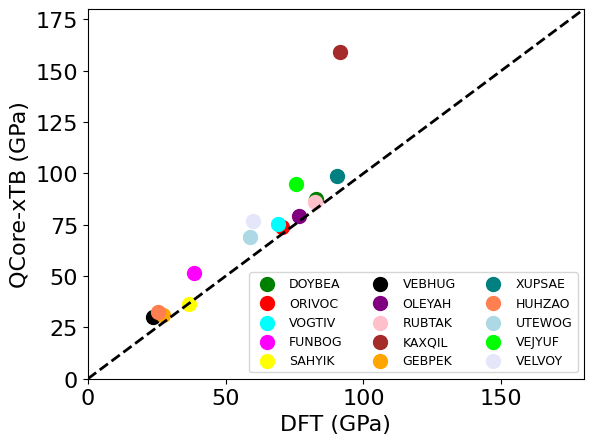

In [12]:
import matplotlib.pyplot as plt

plt.rcdefaults()

count = 0
names_converged_new = []
converged_pairs = []

colorlist = ['blue', 'green', 'red', 'cyan', 'magenta', 
             'yellow', 'black', 'purple', 'pink', 'brown', 
             'orange', 'teal', 'coral', 'lightblue', 'lime', 
             'lavender', 'turquoise', 'darkgreen', 'tan', 
             'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']

error = []
relative_errors = []
for name in names:
    b_xtb = df_xtb.loc[df_xtb["name"]==name]["Bulk modulus [GPa]"].values[0]
    b_dft = df_dft.loc[df_dft["name"]==name]["Bulk modulus [GPa]"].values[0]
    if b_xtb > 0 and b_dft >0:
        count+=1
        names_converged_new.append(name)
        converged_pairs.append([b_dft, b_xtb])
        error.append(np.abs(b_xtb - b_dft))
        relative_errors.append( error[-1] / b_dft)
        plt.scatter(b_dft, b_xtb, c=colorlist[count], s=100, alpha=1, label=name)

print('Mean Absolute Error (GaP)', np.mean(error))
print("Mean relative error (%)", np.mean(relative_errors) * 100.)

# With outlier removed
print('With the outlier removed')
idx = np.argmax(error)
error = np.delete(error, idx)
relative_errors = np.delete(relative_errors, idx)
print('Mean Absolute Error (GaP)', np.mean(error))
print("Mean relative error (%)", np.mean(relative_errors) * 100.)

xr = np.linspace(0, 180, 100)
plt.plot(xr, xr,"--", color='black', lw=2)
plt.xlim([0, 180])
plt.ylim([0, 180])

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel("DFT (GPa)",fontsize=16)
plt.ylabel("QCore-xTB (GPa)",fontsize=16)
plt.legend(loc='lower right', numpoints=1, ncol=3, fontsize=9, bbox_to_anchor=(1, 0))
plt.savefig("mof_bulk_moduli.eps", dpi=300, bbox_inches="tight")

    

QCore eos_murnaghan 155.46053676846634
QE eos_murnaghan 110.95387363422434
QCore eos birch_murnaghan 159.98469961642874
QE eos birch_murnaghan 94.74792214393503


<Axes: xlabel='Volume $\\AA^3$', ylabel='Energy (eV)'>

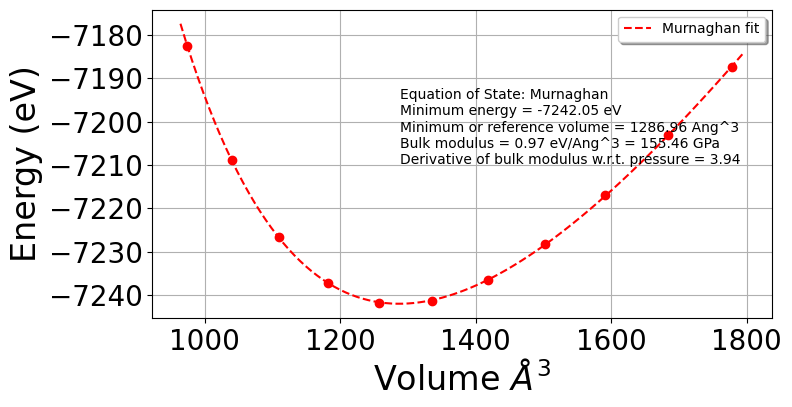

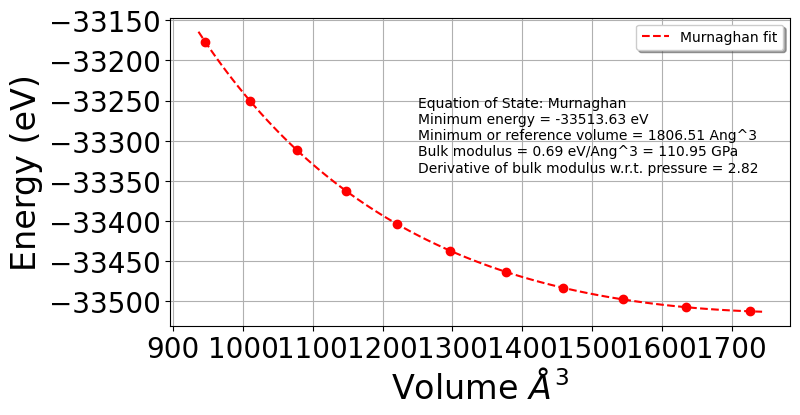

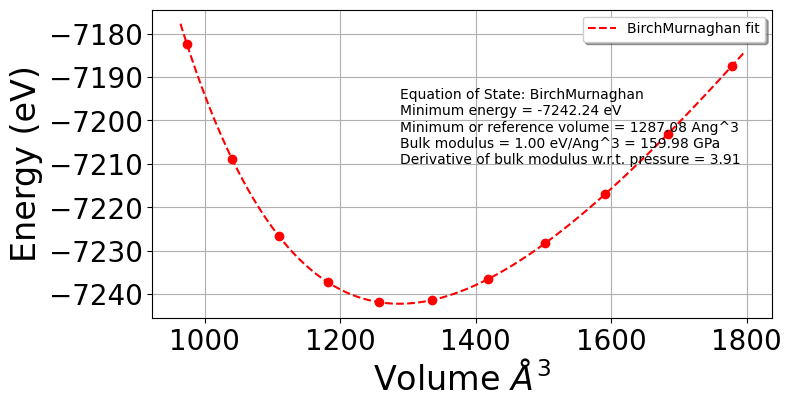

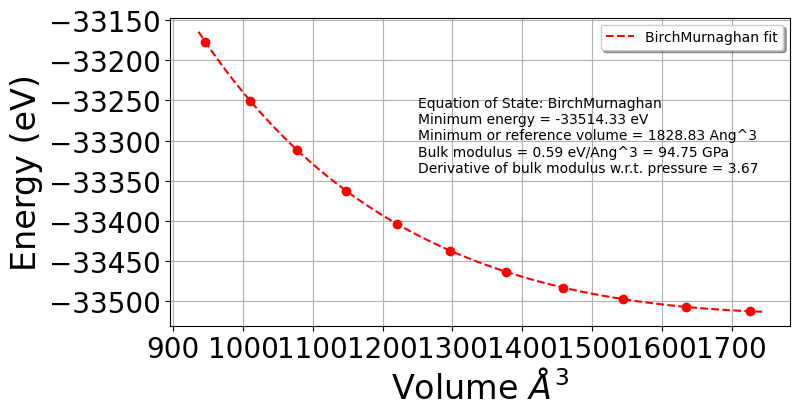

In [19]:
""" Perform E vs V plots, should one wish to reanalyse them
"""
from pymatgen.analysis import eos

def plot_e_vs_v(df, name: str, eos_name: str):
    vols = df.loc[df["name"]==name]["volume"]
    energies = df.loc[df["name"]==name]["energy [kcal/mol]"] * kcal_per_mol_to_ev
    eos_system = eos.EOS(eos_name=eos_name)
    eos_fit = eos_system.fit(vols, energies)
    return eos_fit

# Example for KAXQIL, using two fits
# TODO: Overlay DFTB and QCore
result = plot_e_vs_v(df_xtb, "KAXQIL", 'murnaghan')
print('QCore eos_murnaghan', result.b0_GPa.real)
result.plot()

result = plot_e_vs_v(df_dft, "KAXQIL", 'murnaghan')
print('QE eos_murnaghan', result.b0_GPa.real)
result.plot()

result = plot_e_vs_v(df_xtb, "KAXQIL", 'birch_murnaghan')
print('QCore eos birch_murnaghan', result.b0_GPa.real)
result.plot()

result = plot_e_vs_v(df_dft, "KAXQIL", 'birch_murnaghan')
print('QE eos birch_murnaghan', result.b0_GPa.real)
result.plot()
